As a continuation of the **[Vectorization Strategies Experiment](ML-Task-1_Vectorization-Experiment.ipynb)**, in the following we explore whether **increasing the effective context window of BERT** via a **sliding window mechanism** can improve classification performance of BERT models - maybe even closing the performance gap previously observed to TF-IDF based SVMs.

Remember: We already established that **mean pooling** over token embeddings outperforms the standard [CLS] token strategy in this classification setting.


## **Sliding Window Strategy for Long-Sequence Classification**

- To address the inherent 512 token **input length limitation of the BERT architecture**, this model implements a refined **sliding window mechanism** designed for long parliamentary speeches. Instead of truncating or arbitrarily splitting input sequences—which would risk omitting semantically critical content—the input is partitioned into overlapping segments of fixed maximum length. Each window overlaps with its predecessor by a defined number of tokens (default: 128), preserving contextual continuity across segments.

- All segments are **processed in parallel through the base BERT model**, yielding contextualized hidden states for each token. A **mean pooling** operation is then applied to computes a segment-level embedding, weighted by the attention mask to exclude padding artifacts. These segment embeddings are then aggregated via a global weighted average, producing a **single dense vector** that serves as the comprehensive semantic representation of the full-length input. This representation is subsequently passed through a linear classification head for label prediction.

- The sliding window strategy thus facilitates **context-preserving inference over arbitrarily long sequences**, enabling the model to exploit the full rhetorical and topical richness of extended speeches. It offers a principled alternative to truncation-based processing and we anticipate this approach to be better suited to domains like political discourse.

> **Note:** This experiment is conducted using the **exact same dataset, sampling and train/validation/test split scheme, training parameters and evaluation criteria** as the preceding **[Vectorization Strategies Experiment](ML-Task-1_Vectorization-Experiment.ipynb)**, ensuring a fully controlled and methodologically consistent comparison.
>
> **Note:** Due too their need for considerable processing power and Vram (15 to 35 GB), the following models were trained using Google Colab, which is why their implementation differs slightly from the models shown so far.

In [1]:
!pip uninstall -y -q datasets
!pip install -q --no-deps "transformers==4.52.4"
!pip install -q --no-deps "datasets>=2.19.2"
!pip install -q evaluate accelerate sklearn-compat pyarrow sentencepiece tqdm seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

4.52.4


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

Using device: cuda


Counting tokens:   0%|          | 0/32042 [00:00<?, ?it/s]

Removed 11190 speeches due to outlier speech length. 20852 speeches remain. The length speech is 1086 tokens long.

=== Sample Counts per Class after Balanced Sampling ===

 label_encoded (used for training)  num_samples  faction_id  faction_abbreviation
                                 0         1000           0                   AfD
                                 1         1000           4 Bündnis 90/Die Grünen
                                 2         1000           5               CDU/CSU
                                 3         1000           7            DIE LINKE.
                                 4         1000          15                   FDP
                                 5         1000          25                   SPD


/tmp/ipython-input-2-829973591.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Status"] = "After Filtering"


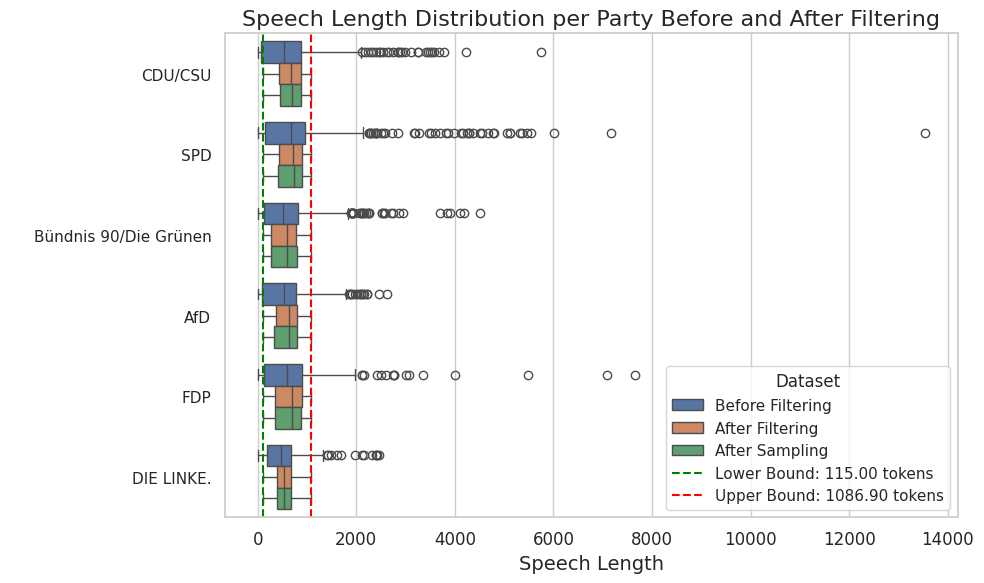

Map:   0%|          | 0/3900 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (815 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

/tmp/ipython-input-2-829973591.py:389: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,No log,1.713792,0.251111,0.199421
2,No log,1.668520,0.281111,0.259312
3,1.672500,1.636688,0.292222,0.262345



Classification Report BERT_MEAN_SLIDING_WINDOW:
                       precision  recall  f1-score   support
AfD                        0.730   0.135     0.228   200.000
Bündnis 90/Die Grünen      0.414   0.275     0.330   200.000
CDU/CSU                    0.266   0.125     0.170   200.000
DIE LINKE.                 0.610   0.375     0.464   200.000
FDP                        0.261   0.030     0.054   200.000
SPD                        0.195   0.770     0.311   200.000
accuracy                   0.285   0.285     0.285     0.285
macro avg                  0.412   0.285     0.260  1200.000
weighted avg               0.412   0.285     0.260  1200.000

=== Evaluation Results for BERT_MEAN_SLIDING_WINDOW ===



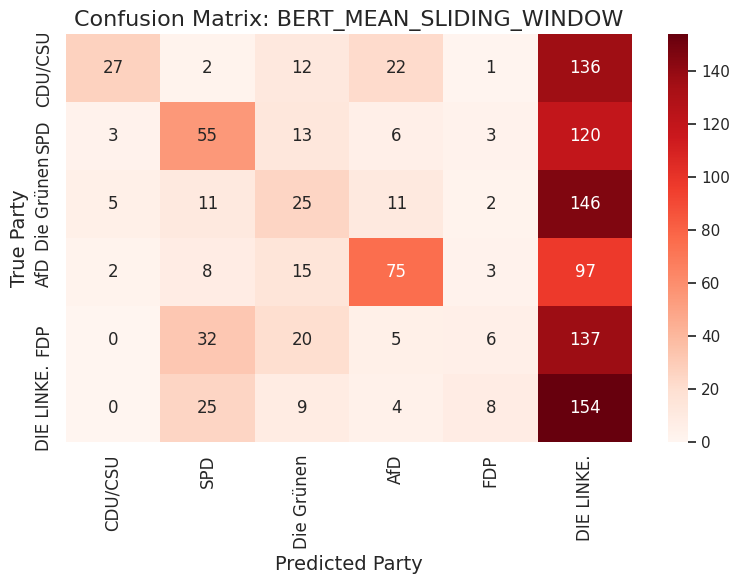


**Confusion Matrix (absolute counts)**

|            |   AfD |   Die Grünen |   CDU/CSU |   DIE LINKE. |   FDP |   SPD |
|:-----------|------:|-------------:|----------:|-------------:|------:|------:|
| AfD        |    27 |            2 |        12 |           22 |     1 |   136 |
| Die Grünen |     3 |           55 |        13 |            6 |     3 |   120 |
| CDU/CSU    |     5 |           11 |        25 |           11 |     2 |   146 |
| DIE LINKE. |     2 |            8 |        15 |           75 |     3 |    97 |
| FDP        |     0 |           32 |        20 |            5 |     6 |   137 |
| SPD        |     0 |           25 |         9 |            4 |     8 |   154 |


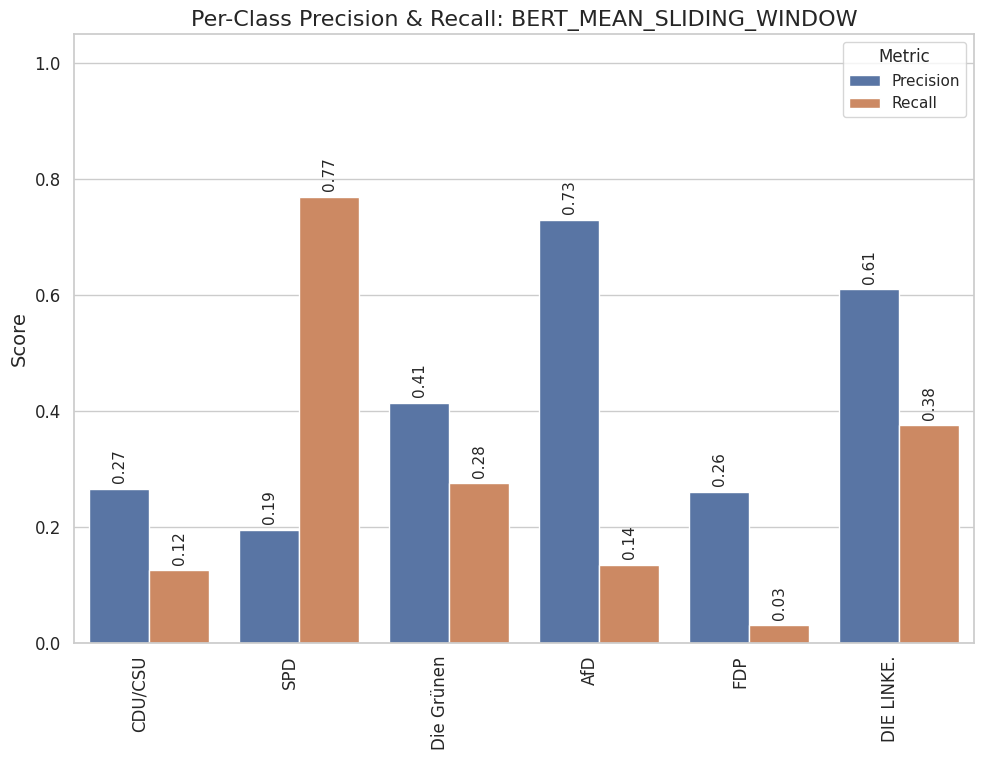


Classification Report:
            precision  recall  f1-score  support
AfD             0.730   0.135     0.228    200.0
Die Grünen      0.414   0.275     0.330    200.0
CDU/CSU         0.266   0.125     0.170    200.0
DIE LINKE.      0.610   0.375     0.464    200.0
FDP             0.261   0.030     0.054    200.0
SPD             0.195   0.770     0.311    200.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# Running in Google Colab
import os
import re
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import transformers
import torch
import torch.nn as nn
from transformers import (BertTokenizer, BertModel,
                          Trainer, TrainingArguments, EarlyStoppingCallback,
                          DataCollatorWithPadding)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
print(transformers.__version__)



def evaluate_model_results(model_name):
    """
    Evaluates classification results for the given model using abbreviations only.
    Produces plots for confusion matrix, precision, and recall per class.

    :param model_name (str): Identifier for result lookup and plots.
    """
    print(f"\n=== Evaluation Results for {model_name} ===\n")

    # Define party order and colors
    order = ["CDU/CSU", "SPD", "Die Grünen", "AfD", "FDP", "DIE LINKE."]
    party_colors = {
        "CDU/CSU": "#000000",
        "SPD": "#E3000F",
        "Die Grünen": "#46962B",
        "FDP": "#FFED00",
        "AfD": "#009EE0",
        "DIE LINKE.": "#BE3075",
    }

    # Load and normalize evaluation data
    raw_cm = confusion_matrices[model_name]["matrix"]
    raw_labels = confusion_matrices[model_name]["labels"]
    raw_report = classification_reports[model_name]

    # Normalize label names (e.g., replace "Bündnis 90 / Die Grünen" with "Die Grünen")
    label_mapping = {
        "Bündnis 90/Die Grünen": "Die Grünen"
    }

    # Apply label mapping
    labels = [label_mapping.get(label, label) for label in raw_labels]

    # Remap confusion matrix to use normalized labels
    label_indices = {old: i for i, old in enumerate(raw_labels)}
    norm_indices = [label_mapping.get(label, label) for label in raw_labels]

    cm_df = pd.DataFrame(raw_cm, index=labels, columns=labels)

    # Remap classification report keys
    report = {}
    for label in raw_labels:
        mapped_label = label_mapping.get(label, label)
        report[mapped_label] = raw_report[label]

    # Label order
    label_order = [label for label in order if label in labels]

    # --- Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Reds", xticklabels=label_order, yticklabels=label_order)
    plt.xlabel("Predicted Party", fontsize=14)
    plt.ylabel("True Party", fontsize=14)
    plt.title(f"Confusion Matrix: {model_name}", fontsize=16)
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Print Confusion Matrix as Markdown table
    print("\n**Confusion Matrix (absolute counts)**\n")
    print(cm_df.to_markdown())

    # --- Combined Precision and Recall Plot ---
    df_combined = pd.DataFrame({
        "Party": label_order * 2,
        "Metric": ["Precision"] * len(label_order) + ["Recall"] * len(label_order),
        "Value": [report[label]["precision"] for label in label_order] +
                 [report[label]["recall"] for label in label_order],
        "Color": [party_colors[label] for label in label_order] * 2
    })

    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=df_combined,
        x="Party",
        y="Value",
        hue="Metric",
        dodge=True,
        palette={"Precision": "#4c72b0", "Recall": "#dd8452"}
    )

    # Annotate each bar with its value
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f"{height:.2f}",
                        (p.get_x() + p.get_width() / 2., height + 0.01),
                        ha='center', va='bottom', rotation=90, fontsize=11)

    plt.ylim(0, 1.05)
    plt.title(f"Per-Class Precision & Recall: {model_name}", fontsize=16)
    plt.ylabel("Score", fontsize=14)
    plt.xlabel(" ")
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=90, ha="right")
    plt.legend(title="Metric", loc="upper right")
    plt.tight_layout()
    plt.show()

    # --- Full Report ---
    report_df = pd.DataFrame(report).transpose()
    print("\nClassification Report:")
    print(report_df[["precision", "recall", "f1-score", "support"]].round(3))



from transformers.modeling_outputs import SequenceClassifierOutput
class BertMeanPoolingClassifierSliding(nn.Module):
    def __init__(self, model_name, num_labels, max_length=512, overlap=128):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()
        self.max_length = max_length
        self.overlap = overlap


    def sliding_window(self, input_ids, attention_mask, device):
        """
        Schneidet eine Sequenz in überlappende Fenster und erzeugt
        ein globales Mean-Pooled-Embedding, gewichtet über alle Tokens.
        """
        ids = input_ids.tolist()
        mask = attention_mask.tolist()

        # Fenster bilden
        segments, seg_masks = [], []
        step = self.max_length - self.overlap
        for i in range(0, len(ids), step):
            chunk_ids  = ids[i : i + self.max_length]
            chunk_mask = mask[i : i + self.max_length]

            pad_len = self.max_length - len(chunk_ids)
            if pad_len:
                chunk_ids  += [tokenizer.pad_token_id] * pad_len
                chunk_mask += [0] * pad_len

            segments.append(chunk_ids)
            seg_masks.append(chunk_mask)

        segments  = torch.tensor(segments,  dtype=torch.long, device=device)
        seg_masks = torch.tensor(seg_masks, dtype=torch.long, device=device)
        seg_types = torch.zeros_like(segments)            # NEW: token_type_ids=0

        # BERT über alle Segmente in einem Rutsch
        out = self.bert(
            input_ids     = segments,
            attention_mask= seg_masks,
            token_type_ids= seg_types                     # NEW
        ).last_hidden_state                               # (n_seg, L, H)

        # Mean Pooling pro Segment (Padding wird ignoriert)
        mask_exp     = seg_masks.unsqueeze(-1).expand(out.size()).float()
        seg_token_sum= (out * mask_exp).sum(1)            # (n_seg, H)
        seg_len      = mask_exp.sum(1)                    # (n_seg, 1)

        # Globale gewichtete Summe
        global_sum = seg_token_sum.sum(0)                 # (H,)
        total_len  = seg_len.sum()                        # Skalar

        return global_sum / total_len                    # (H,)


    def forward(self, input_ids, attention_mask, labels=None):
        device = input_ids.device
        pooled = []

        for i in range(input_ids.size(0)):           # Batch loop
            seq_len = int(attention_mask[i].sum())   # echte Token-Länge

            if seq_len > self.max_length:            # >512 → Sliding Window
                emb = self.sliding_window(
                    input_ids[i], attention_mask[i], device
                )
            else:                                    # ≤512 → direkt in BERT
                # --- NEU: nur den nicht-gepolsterten Teil übergeben -----------
                ids_slice   = input_ids[i, :seq_len].unsqueeze(0)
                mask_slice  = attention_mask[i, :seq_len].unsqueeze(0)
                types_slice = torch.zeros_like(ids_slice)  # token_type_ids=0
                # ----------------------------------------------------------------

                last_hidden = self.bert(
                    input_ids      = ids_slice,
                    attention_mask = mask_slice,
                    token_type_ids = types_slice
                ).last_hidden_state                       # (1, seq_len, H)

                mask_exp = mask_slice.unsqueeze(-1).expand(last_hidden.size()).float()
                emb = (last_hidden * mask_exp).sum(1) / mask_exp.sum(1)  # mean pool
                emb = emb.squeeze(0)                     # (H,)

            pooled.append(emb)

        pooled = torch.stack(pooled)                     # (B, H)
        logits = self.classifier(pooled)
        loss   = self.loss_fn(logits, labels) if labels is not None else None
        return SequenceClassifierOutput(loss=loss, logits=logits)



"""
Setup constants
"""
# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Models & Tokenizer
MODEL_NAME = "bert-base-german-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
LEARNING_RATE = 1e-5
NUM_LABELS = 6  # will later also be adjustet based on the number of uniqe parties in the dataset
BATCH_SIZE = 16
EPOCHS = 3
MAX_SAMPLE_SIZE_PARTY=1000 # speech counts of parties need to be double checked after filtering
TEST_SPLIT_SIZE=0.2
VALIDATION_SPLIT_SIZE = 0.15
UPPER_PERCENTILE = 0.9
LOWER_PERCENTILE = 0.25



"""
Global variables
"""
# Global dictionary to store all confusion matrices by model name
confusion_matrices = {}
# Global dictionary to collect classification reports per model
classification_reports = {}
# Load faction map
faction_map = pd.read_pickle("factionsAbbreviations.pkl").drop_duplicates(subset="id").set_index("id")["abbreviation"]
# Set device type explicitly for MPS (Apple Silicon), CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



"""
Tokenization and dataset conversion
"""
def remove_contribution_markers(text: str) -> str:
    """
    - collapses whitespace
    - Removes content in square brackets like [Beifall], [Zwischenruf], etc.
    - Removes contribution position placeholders in the form of ({123})

    :param text (str): Raw speech text
    :return text (str): Normalized speech text
    """
    if not isinstance(text, str):
        return text  # Skip non-string entries (if any)
    text = re.sub(r'\[.*?\]', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r'\(\{\d+\}\)', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def prepare_dataset_BERT(df):
    """
    Wandelt das DataFrame in ein HF-Dataset ohne globales Padding um.
    Jede Rede bleibt in voller Länge erhalten; gepolstert
    wird erst *im* Batch durch den DataCollator.
    """
    df["speech_content"] = df["speech_content"].apply(remove_contribution_markers)
    ds = Dataset.from_pandas(df[["speech_content", "label_encoded"]])

    ds = ds.map(
        lambda x: tokenizer(
            x["speech_content"],
            add_special_tokens=True,   # [CLS] … [SEP]
            padding=False,             # **kein** Padding hier!
            truncation=False           # wir schneiden nicht ab – Sliding Window macht das später
        ),
        batched=True
    )

    ds = ds.rename_column("label_encoded", "labels")
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }



"""
Training Loop for BERT on mean pooling embeddings
"""
def train_bert_mean_sliding_window(train_df, test_df, val_df, model_name):
    """
    Training Loop for BERT

    :param: train_df (Dataset): training dataset.
    :param: test_df (Dataset): testing dataset.
    :param: model_name (str): Identifier for logging and visualizations.

    :return: None
    """
    # Prepare Datasets (Train, Val, Test)
    train_ds = prepare_dataset_BERT(train_df)
    val_ds   = prepare_dataset_BERT(val_df)
    test_ds  = prepare_dataset_BERT(test_df)

    # Initialize BERT model and trainer and move to device
    model = BertMeanPoolingClassifierSliding(MODEL_NAME, NUM_LABELS).to(device)

    # Set training arguments for the HuggingFace trainer
    training_args = TrainingArguments(
        output_dir="tmp",                 # Pflicht-Arg!
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        report_to="none",
        run_name="BERT_CLS_SLIDING_WINDOW"
    )

    collator = DataCollatorWithPadding(
        tokenizer,
        pad_to_multiple_of=8, # CUDA-friendly; für CPU einfach weglassen
        return_tensors="pt"
    )

    # Trainer object initialization
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(3, 0.0)]
    )

    # train model
    trainer.train()


    # Predicting and decoding labels
    preds = trainer.predict(test_ds)
    y_true_enc = preds.label_ids
    y_pred_enc = np.argmax(preds.predictions, axis=1)

    # Map to faction abbreviations for readability
    y_true_abbr = test_df.reset_index(drop=True).iloc[:, :]["label_encoded"].map(label_to_fid).map(faction_map)
    y_pred_abbr = pd.Series(y_pred_enc).map(label_to_fid).map(faction_map)

    # Get sorted unique abbreviations for consistent plotting
    unique_abbr = sorted(y_true_abbr.unique())


    # Compute confusion matrix
    cm_local = confusion_matrix(y_true_abbr, y_pred_abbr, labels=unique_abbr)
    confusion_matrices[model_name] = {
        "matrix": cm_local,
        "labels": unique_abbr
    }

    # Classification report using readable party names
    report = classification_report(
        y_true_abbr,
        y_pred_abbr,
        labels=unique_abbr,
        target_names=unique_abbr,
        digits=3,
        output_dict=True
    )
    classification_reports[model_name] = report

    print(f"\nClassification Report {model_name}:")
    print(pd.DataFrame(report).transpose().round(3))



"""
Load and encode data
"""

# Load full raw dataset with raw speech text and faction_id
df = pd.read_pickle("speech_content_20.pkl")
# Drop rows with missing labels or empty text
df = df[df["faction_id"] != -1].dropna(subset=["speech_content"])
# Filter valid faction (without fraktionslos)
valid_ids = [0, 3, 4, 5, 7, 15, 25]
df = df[df["faction_id"].isin(valid_ids)].copy()
df.loc[df["faction_id"] == 3, "faction_id"] = 7 # merging BSW into DIE LINKE.
# add abbreviations to data set
df["faction_abbreviation"] = df["faction_id"].map(faction_map)

# encode labels (necessary for good BERT classification)
encoder = LabelEncoder()
df["label_encoded"] = encoder.fit_transform(df["faction_id"]) # column will later be named label
NUM_LABELS = len(encoder.classes_)
# label_encoded → original faction_id
label_to_fid = dict(zip(df["label_encoded"], df["faction_id"]))



"""
Filter speech lengths for BERT and SVM Models
"""
# Token count via tokenizer with progress bar
tqdm.pandas(desc="Counting tokens")
df["token_count"] = df["speech_content"].progress_apply(lambda text: len(tokenizer.tokenize(text)))

# copy for plt
df_old = df.copy()

# Outlier filtering using Quantils
lower_bound = df["token_count"].quantile(LOWER_PERCENTILE)
upper_bound = df["token_count"].quantile(UPPER_PERCENTILE)

# filter and report
df = df[(df["token_count"] >= lower_bound) & (df["token_count"] <= upper_bound)]
max_speech = df["token_count"].max()
print(f"Removed {len(df_old) - len(df)} speeches due to outlier speech length. {len(df)} speeches remain. The length speech is {max_speech} tokens long.")



"""
Unified Train-Test Split and Balanced Sampling for BERT and SVM Models
"""
# Balanced Sampling
balanced_df = pd.concat([
    party_df.sample(min(len(party_df), MAX_SAMPLE_SIZE_PARTY), random_state=SEED)
    for _, party_df in df.groupby("label_encoded")
])
# copy for plot
df_after_sampling = balanced_df.copy()

# Anzeige
sample_counts = balanced_df.groupby("label_encoded").agg(
    num_samples=("label_encoded", "count"),
    faction_id=("faction_id", "first"),
    faction_abbreviation=("faction_abbreviation", "first")
).reset_index().rename(columns={"label_encoded": "label_encoded (used for training)"})
print("\n=== Sample Counts per Class after Balanced Sampling ===\n")
print(sample_counts.to_string(index=False))

# === grouped Boxplot df_old and df ===
df_old["Status"] = "Before Filtering"
df["Status"] = "After Filtering"
df_after_sampling["Status"] = "After Sampling"
# combine
df_combined = pd.concat([df_old, df, df_after_sampling], axis=0)
# bpxplot
order = ["CDU/CSU", "SPD", "Bündnis 90/Die Grünen", "AfD", "FDP", "DIE LINKE."]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x="token_count", y="faction_abbreviation", hue="Status", order=order, showfliers=True)
plt.axvline(lower_bound, color="green", linestyle="--", label=f"Lower Bound: {lower_bound:.2f} tokens")
plt.axvline(upper_bound, color="red", linestyle="--", label=f"Upper Bound: {upper_bound:.2f} tokens")
plt.title("Speech Length Distribution per Party Before and After Filtering", fontsize=16)
plt.xlabel("Speech Length", fontsize=14)
plt.ylabel(" ")
plt.xticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)
plt.legend(title="Dataset", loc="lower right")
plt.tight_layout()
save_and_show_plot("grouped Boxplot df_old and df MEAN_SLIDING_WINDOW.png")

# Unified Train-Test Split (Train/Val/Test)
train_df, temp_df = train_test_split(
    balanced_df,
    test_size=TEST_SPLIT_SIZE + VALIDATION_SPLIT_SIZE,
    stratify=balanced_df["label_encoded"],
    random_state=SEED
)
val_size_rel = VALIDATION_SPLIT_SIZE / (TEST_SPLIT_SIZE + VALIDATION_SPLIT_SIZE)
val_df, test_df = train_test_split(
    temp_df,
    test_size=1 - val_size_rel,
    stratify=temp_df["label_encoded"],
    random_state=SEED
)



"""
Start BERT training and evaluation
"""
# Tokenization and training for BERT_MEAN
train_bert_mean_sliding_window(train_df, test_df, val_df, "BERT_MEAN_SLIDING_WINDOW")
evaluate_model_results("BERT_MEAN_SLIDING_WINDOW")

## **Diagnostic review of the mean-pooled sliding-window approach**

This first implementation achieved only **28 % overall accuracy** despite a **perfectly balanced training set** (1,000 speeches per party) — one of the worst results we have seen so far and nowhere near the SVMs performance in th [Vectorization Strategies Experiment](ML-Task-1_Vectorization-Experiment.ipynb).

- A glance at the **confusion matrix** shows why: The classifier mis-routed more than half of all test samples to `SPD`, yielding a recall of 78 % for `SPD`, while every other party stayed between 3 % and 37 %.
- This **systematic bias** suggests that the six class-centroids in embedding space collapsed into a single, largely undifferentiated region.

So why did this happen?

- This model split long speeches into overlapping segments, ran each segment through BERT, **mean-pooled** every token inside each window, and finally averaged those window-vectors once more. We suspect that unfortunately, mean-pooling globally over all tokens lead to high-frequency function words outweighing the few party-specific keywords that actually separate factions; almost every speech is reduced to a **very similar “grey” vector** — so the model learned to map anything to the majority output neuron.
- Also, utilizing only one linear layer, no non-linearity as well as no dropout may keep the model's capacity too low to carve out subtle lexical or stylistic differences in the training data, which leads to even less precision for all minority classes and overconfidence in a single class.


## **Targeted modifications and expected gains:**

1. **Ditch full-token mean pooling** for CLS pooling per window – we now keep only the [CLS] embedding of each segment and average those, hopefully giving clearer, more distinctive representations by preserving inter-window variety. We anticipate higher inter-class separation (fewer SPD “mode collapses”) because of this modification.
2. **A deeper classification head** allows the model to learn non-linear decision boundaries and reduces over-fitting to the majority prediction – a new design with two linear layers and dropout (`Linear ➜ ReLU ➜ Dropout ➜ Linear`) is expected to yield better precision and recall, especially for syntactically similar parties.
3. **Higher learning rate (2 e-5) and longer training (5 epochs)** ensures the fine-tuning step actually moves the encoder away from its initialization.

Taken together, these adjustments should break the SPD bias, **raise macro-F1 from 0 .26 to the mid-0 .40s** or higher, and produce more balanced confusion matrix, yielding a materially fairer and more informative classifier.

4.52.4
Using device: cuda


Counting tokens:   0%|          | 0/32042 [00:00<?, ?it/s]

Removed 11190 speeches due to outlier speech length. 20852 speeches remain. The length speech is 1086 tokens long.

=== Sample Counts per Class after Balanced Sampling ===

 label_encoded (used for training)  num_samples  faction_id  faction_abbreviation
                                 0         1000           0                   AfD
                                 1         1000           4 Bündnis 90/Die Grünen
                                 2         1000           5               CDU/CSU
                                 3         1000           7            DIE LINKE.
                                 4         1000          15                   FDP
                                 5         1000          25                   SPD


/tmp/ipython-input-4-3141723553.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Status"] = "After Filtering"


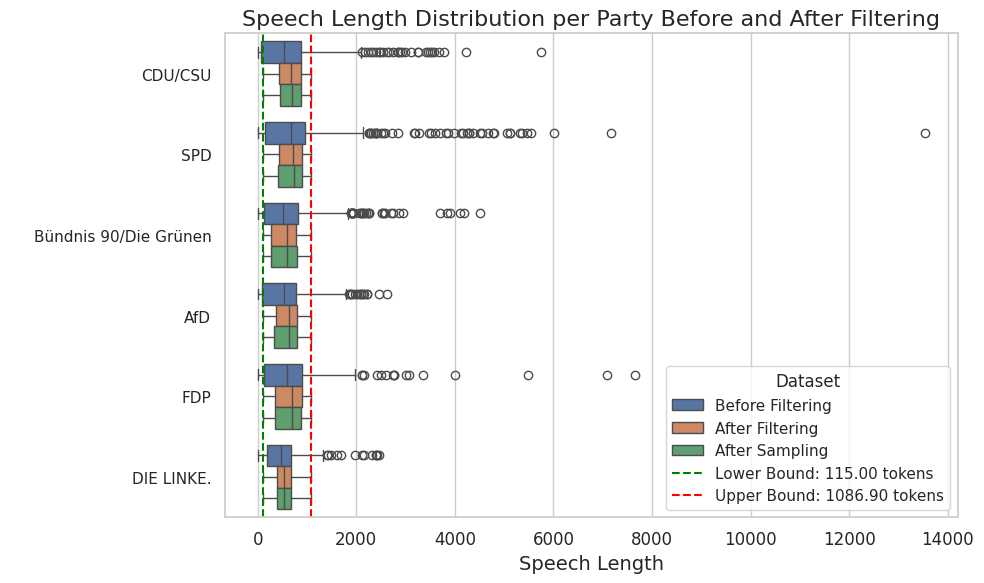

Map:   0%|          | 0/3900 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (815 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

/tmp/ipython-input-4-3141723553.py:368: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,No log,1.449793,0.388889,0.366760
2,No log,1.278755,0.485556,0.469769
3,1.381600,1.190781,0.541111,0.531500
4,1.381600,1.165823,0.588889,0.579371
5,0.852000,1.142457,0.588889,0.583329


[Saved] Best checkpoint written to: models/BERT_CLS_SLIDING_WINDOW_best



Classification Report BERT_CLS_SLIDING_WINDOW:
                       precision  recall  f1-score   support
AfD                        0.925   0.680     0.784   200.000
Bündnis 90/Die Grünen      0.438   0.545     0.486   200.000
CDU/CSU                    0.510   0.620     0.560   200.000
DIE LINKE.                 0.660   0.785     0.717   200.000
FDP                        0.314   0.245     0.275   200.000
SPD                        0.413   0.345     0.376   200.000
accuracy                   0.537   0.537     0.537     0.537
macro avg                  0.543   0.537     0.533  1200.000
weighted avg               0.543   0.537     0.533  1200.000

=== Evaluation Results for BERT_CLS_SLIDING_WINDOW ===



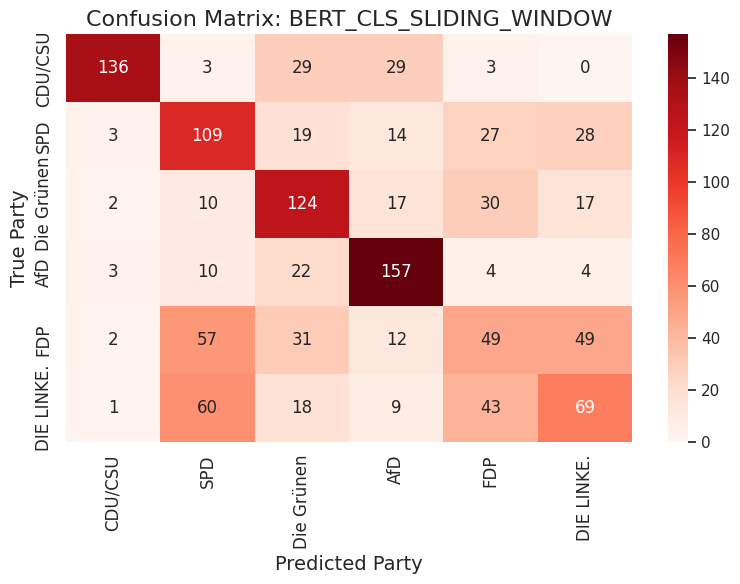


**Confusion Matrix (absolute counts)**

|            |   AfD |   Die Grünen |   CDU/CSU |   DIE LINKE. |   FDP |   SPD |
|:-----------|------:|-------------:|----------:|-------------:|------:|------:|
| AfD        |   136 |            3 |        29 |           29 |     3 |     0 |
| Die Grünen |     3 |          109 |        19 |           14 |    27 |    28 |
| CDU/CSU    |     2 |           10 |       124 |           17 |    30 |    17 |
| DIE LINKE. |     3 |           10 |        22 |          157 |     4 |     4 |
| FDP        |     2 |           57 |        31 |           12 |    49 |    49 |
| SPD        |     1 |           60 |        18 |            9 |    43 |    69 |


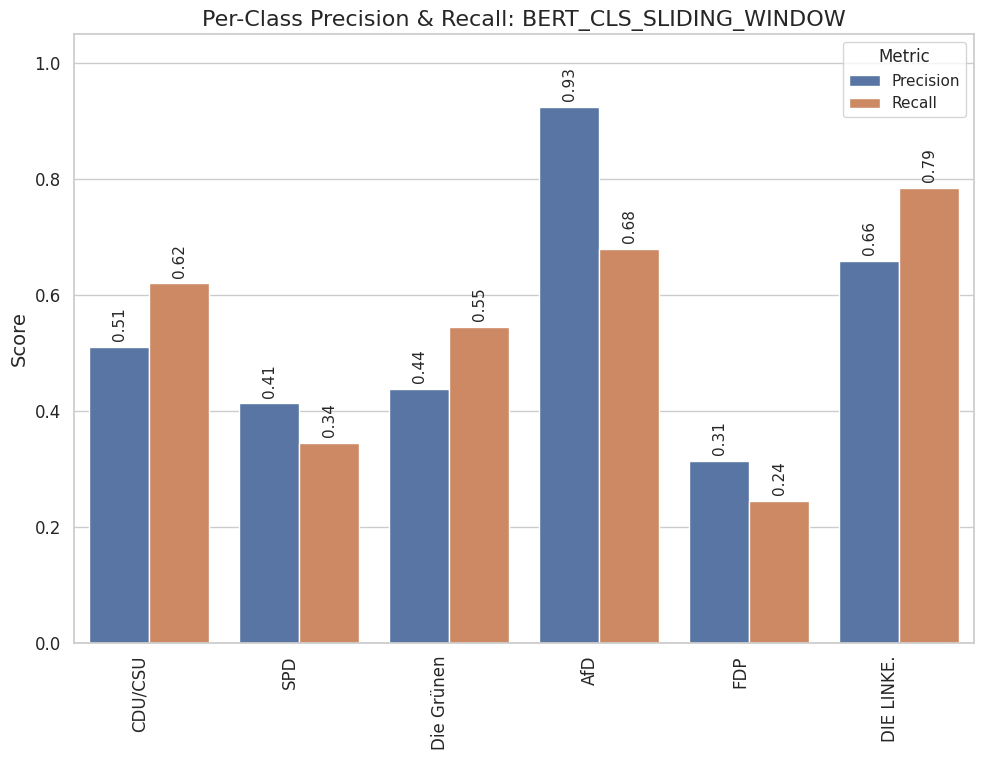


Classification Report:
            precision  recall  f1-score  support
AfD             0.925   0.680     0.784    200.0
Die Grünen      0.438   0.545     0.486    200.0
CDU/CSU         0.510   0.620     0.560    200.0
DIE LINKE.      0.660   0.785     0.717    200.0
FDP             0.314   0.245     0.275    200.0
SPD             0.413   0.345     0.376    200.0


In [4]:
# Running in Google Colab
# !pip install -q -U "transformers>=4.41.1" "datasets>=2.19.0" "evaluate>=0.4.0" "accelerate" "scikit-learn" "tqdm" "matplotlib" "seaborn"

import os
import re
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import transformers
import torch
import torch.nn as nn
from transformers import (BertTokenizer, BertModel,
                          Trainer, TrainingArguments, EarlyStoppingCallback,
                          DataCollatorWithPadding)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
print(transformers.__version__)
sns.set(style="whitegrid")
from google.colab import files
import pickle


# save the model
MODEL_SAVE_BASE_DIR = "models"
os.makedirs(MODEL_SAVE_BASE_DIR, exist_ok=True)



def evaluate_model_results(model_name):
    """
    Evaluates classification results for the given model using abbreviations only.
    Produces plots for confusion matrix, precision, and recall per class.

    :param model_name (str): Identifier for result lookup and plots.
    """
    print(f"\n=== Evaluation Results for {model_name} ===\n")

    # Define party order and colors
    order = ["CDU/CSU", "SPD", "Die Grünen", "AfD", "FDP", "DIE LINKE."]
    party_colors = {
        "CDU/CSU": "#000000",
        "SPD": "#E3000F",
        "Die Grünen": "#46962B",
        "FDP": "#FFED00",
        "AfD": "#009EE0",
        "DIE LINKE.": "#BE3075",
    }

    # Load and normalize evaluation data
    raw_cm = confusion_matrices[model_name]["matrix"]
    raw_labels = confusion_matrices[model_name]["labels"]
    raw_report = classification_reports[model_name]

    # Normalize label names (e.g., replace "Bündnis 90 / Die Grünen" with "Die Grünen")
    label_mapping = {
        "Bündnis 90/Die Grünen": "Die Grünen"
    }

    # Apply label mapping
    labels = [label_mapping.get(label, label) for label in raw_labels]

    # Remap confusion matrix to use normalized labels
    label_indices = {old: i for i, old in enumerate(raw_labels)}
    norm_indices = [label_mapping.get(label, label) for label in raw_labels]

    cm_df = pd.DataFrame(raw_cm, index=labels, columns=labels)

    # Remap classification report keys
    report = {}
    for label in raw_labels:
        mapped_label = label_mapping.get(label, label)
        report[mapped_label] = raw_report[label]

    # Label order
    label_order = [label for label in order if label in labels]

    # --- Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Reds", xticklabels=label_order, yticklabels=label_order)
    plt.xlabel("Predicted Party", fontsize=14)
    plt.ylabel("True Party", fontsize=14)
    plt.title(f"Confusion Matrix: {model_name}", fontsize=16)
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Print Confusion Matrix as Markdown table
    print("\n**Confusion Matrix (absolute counts)**\n")
    print(cm_df.to_markdown())

    # --- Combined Precision and Recall Plot ---
    df_combined = pd.DataFrame({
        "Party": label_order * 2,
        "Metric": ["Precision"] * len(label_order) + ["Recall"] * len(label_order),
        "Value": [report[label]["precision"] for label in label_order] +
                 [report[label]["recall"] for label in label_order],
        "Color": [party_colors[label] for label in label_order] * 2
    })

    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=df_combined,
        x="Party",
        y="Value",
        hue="Metric",
        dodge=True,
        palette={"Precision": "#4c72b0", "Recall": "#dd8452"}
    )

    # Annotate each bar with its value
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f"{height:.2f}",
                        (p.get_x() + p.get_width() / 2., height + 0.01),
                        ha='center', va='bottom', rotation=90, fontsize=11)

    plt.ylim(0, 1.05)
    plt.title(f"Per-Class Precision & Recall: {model_name}", fontsize=16)
    plt.ylabel("Score", fontsize=14)
    plt.xlabel(" ")
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=90, ha="right")
    plt.legend(title="Metric", loc="upper right")
    plt.tight_layout()
    plt.show()

    # --- Full Report ---
    report_df = pd.DataFrame(report).transpose()
    print("\nClassification Report:")
    print(report_df[["precision", "recall", "f1-score", "support"]].round(3))



from transformers.modeling_outputs import SequenceClassifierOutput
class BertWindowCLSClassifier(nn.Module):          # ← neuer Klassenname
    def __init__(self, model_name, num_labels,
                 max_length=512, overlap=128, p_dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(p_dropout)

        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(self.bert.config.hidden_size, num_labels)
        )

        # Klassengewichtetes Loss (hilft, falls Ihr Balancing nicht 100 % gleichmäßig ist)
        self.loss_fn = nn.CrossEntropyLoss()
        self.max_length = max_length
        self.overlap = overlap


    def sliding_window(self, input_ids, attention_mask, device):
        ids  = input_ids.tolist()
        mask = attention_mask.tolist()

        step = self.max_length - self.overlap
        segments, seg_masks = [], []
        for i in range(0, len(ids), step):
            chunk_ids  = ids[i : i + self.max_length]
            chunk_mask = mask[i : i + self.max_length]
            pad_len = self.max_length - len(chunk_ids)
            if pad_len:
                chunk_ids  += [tokenizer.pad_token_id] * pad_len
                chunk_mask += [0] * pad_len
            segments.append(chunk_ids)
            seg_masks.append(chunk_mask)

        segments  = torch.tensor(segments,  dtype=torch.long, device=device)
        seg_masks = torch.tensor(seg_masks, dtype=torch.long, device=device)
        seg_types = torch.zeros_like(segments)

        # ---------- NEU: wir nehmen nur den [CLS]-Token jeder Sequenz ----------
        cls_embs = self.bert(
            input_ids     = segments,
            attention_mask= seg_masks,
            token_type_ids= seg_types
        ).last_hidden_state[:, 0, :]                 # (n_seg, H)
        return cls_embs.mean(dim=0)                  # (H,)


    def forward(self, input_ids, attention_mask, labels=None):
        device = input_ids.device
        pooled = []

        for i in range(input_ids.size(0)):
            seq_len = int(attention_mask[i].sum())
            if seq_len > self.max_length:            # Sliding Window
                emb = self.sliding_window(
                    input_ids[i], attention_mask[i], device
                )
            else:                                    # ≤512 Tokens
                ids_slice   = input_ids[i, :seq_len].unsqueeze(0)
                mask_slice  = attention_mask[i, :seq_len].unsqueeze(0)
                types_slice = torch.zeros_like(ids_slice)

                emb = self.bert(
                    input_ids      = ids_slice,
                    attention_mask = mask_slice,
                    token_type_ids = types_slice
                ).last_hidden_state[0, 0, :]         # [CLS] eines einzigen Segments
            pooled.append(emb)

        pooled = torch.stack(pooled)                 # (B, H)
        logits = self.classifier(self.dropout(pooled))

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return SequenceClassifierOutput(loss=loss, logits=logits)



"""
Setup constants
"""
# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Models & Tokenizer
MODEL_NAME = "bert-base-german-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
LEARNING_RATE = 2e-5
NUM_LABELS = 6  # will later also be adjustet based on the number of uniqe parties in the dataset
BATCH_SIZE = 16
EPOCHS = 5
MAX_SAMPLE_SIZE_PARTY=1000 # speech counts of parties need to be double checked after filtering
TEST_SPLIT_SIZE=0.2
VALIDATION_SPLIT_SIZE = 0.15
UPPER_PERCENTILE = 0.9
LOWER_PERCENTILE = 0.25



"""
Global variables
"""
# Global dictionary to store all confusion matrices by model name
confusion_matrices = {}
# Global dictionary to collect classification reports per model
classification_reports = {}
# Load faction map
faction_map = pd.read_pickle("factionsAbbreviations.pkl").drop_duplicates(subset="id").set_index("id")["abbreviation"]
# Set device type explicitly for MPS (Apple Silicon), CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



"""
Tokenization and dataset conversion
"""
def remove_contribution_markers(text: str) -> str:
    """
    - collapses whitespace
    - Removes content in square brackets like [Beifall], [Zwischenruf], etc.
    - Removes contribution position placeholders in the form of ({123})

    :param text (str): Raw speech text
    :return text (str): Normalized speech text
    """
    if not isinstance(text, str):
        return text  # Skip non-string entries (if any)
    text = re.sub(r'\[.*?\]', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r'\(\{\d+\}\)', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def prepare_dataset_BERT(df):
    """
    Wandelt das DataFrame in ein HF-Dataset ohne globales Padding um.
    Jede Rede bleibt in voller Länge erhalten; gepolstert
    wird erst *im* Batch durch den DataCollator.
    """
    df["speech_content"] = df["speech_content"].apply(remove_contribution_markers)
    ds = Dataset.from_pandas(df[["speech_content", "label_encoded"]])

    ds = ds.map(
        lambda x: tokenizer(
            x["speech_content"],
            add_special_tokens=True,   # [CLS] … [SEP]
            padding=False,             # **kein** Padding hier!
            truncation=False           # wir schneiden nicht ab – Sliding Window macht das später
        ),
        batched=True
    )

    ds = ds.rename_column("label_encoded", "labels")
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }



"""
Training Loop for BERT on mean pooling embeddings
"""
def train_bert_cls_sliding_window(train_df, test_df, val_df, model_name):
    """
    Training Loop for BERT

    :param: train_df (Dataset): training dataset.
    :param: test_df (Dataset): testing dataset.
    :param: model_name (str): Identifier for logging and visualizations.

    :return: None
    """
    # Prepare Datasets (Train, Val, Test)
    train_ds = prepare_dataset_BERT(train_df)
    val_ds   = prepare_dataset_BERT(val_df)
    test_ds  = prepare_dataset_BERT(test_df)

    # Initialize BERT model and trainer and move to device
    model = BertWindowCLSClassifier(MODEL_NAME, NUM_LABELS).to(device)

    # Set training arguments for the HuggingFace trainer
    training_args = TrainingArguments(
        output_dir="tmp",                 # Pflicht-Arg!
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        report_to="none",
        run_name="BERT_CLS_SLIDING_WINDOW"
    )

    collator = DataCollatorWithPadding(
        tokenizer,
        pad_to_multiple_of=8, # CUDA-friendly; für CPU einfach weglassen
        return_tensors="pt"
    )

    # Trainer object initialization
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(3, 0.0)]
    )

    # train model
    trainer.train()


    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> #
    # SAVE THE BEST MODEL, TOKENIZER & LABEL ENCODER
    best_dir = Path(MODEL_SAVE_BASE_DIR) / f"{model_name}_best"
    best_dir.mkdir(parents=True, exist_ok=True)
    # 1) model + config
    trainer.save_model(best_dir)              # HF-style saver
    # 2) tokenizer
    tokenizer.save_pretrained(best_dir)
    # 3) fitted LabelEncoder (needed for decoding predictions later)
    with open(best_dir / "label_encoder.pkl", "wb") as f:
        pickle.dump(encoder, f)
    print(f"[Saved] Best checkpoint written to: {best_dir}")
    # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< #


    # Predicting and decoding labels
    preds = trainer.predict(test_ds)
    y_true_enc = preds.label_ids
    y_pred_enc = np.argmax(preds.predictions, axis=1)

    # Map to faction abbreviations for readability
    y_true_abbr = test_df.reset_index(drop=True).iloc[:, :]["label_encoded"].map(label_to_fid).map(faction_map)
    y_pred_abbr = pd.Series(y_pred_enc).map(label_to_fid).map(faction_map)

    # Get sorted unique abbreviations for consistent plotting
    unique_abbr = sorted(y_true_abbr.unique())


    # Compute confusion matrix
    cm_local = confusion_matrix(y_true_abbr, y_pred_abbr, labels=unique_abbr)
    confusion_matrices[model_name] = {
        "matrix": cm_local,
        "labels": unique_abbr
    }

    # Classification report using readable party names
    report = classification_report(
        y_true_abbr,
        y_pred_abbr,
        labels=unique_abbr,
        target_names=unique_abbr,
        digits=3,
        output_dict=True
    )
    classification_reports[model_name] = report

    print(f"\nClassification Report {model_name}:")
    print(pd.DataFrame(report).transpose().round(3))



"""
Load and encode data
"""

# Load full raw dataset with raw speech text and faction_id
df = pd.read_pickle("speech_content_20.pkl")
# Drop rows with missing labels or empty text
df = df[df["faction_id"] != -1].dropna(subset=["speech_content"])
# Filter valid faction (without fraktionslos)
valid_ids = [0, 3, 4, 5, 7, 15, 25]
df = df[df["faction_id"].isin(valid_ids)].copy()
df.loc[df["faction_id"] == 3, "faction_id"] = 7 # merging BSW into DIE LINKE.
# add abbreviations to data set
df["faction_abbreviation"] = df["faction_id"].map(faction_map)

# encode labels (necessary for good BERT classification)
encoder = LabelEncoder()
df["label_encoded"] = encoder.fit_transform(df["faction_id"]) # column will later be named label
NUM_LABELS = len(encoder.classes_)
# label_encoded → original faction_id
label_to_fid = dict(zip(df["label_encoded"], df["faction_id"]))



"""
Filter speech lengths for BERT and SVM Models
"""
# Token count via tokenizer with progress bar
tqdm.pandas(desc="Counting tokens")
df["token_count"] = df["speech_content"].progress_apply(lambda text: len(tokenizer.tokenize(text)))

# copy for plt
df_old = df.copy()

# Outlier filtering using Quantils
lower_bound = df["token_count"].quantile(LOWER_PERCENTILE)
upper_bound = df["token_count"].quantile(UPPER_PERCENTILE)

# filter and report
df = df[(df["token_count"] >= lower_bound) & (df["token_count"] <= upper_bound)]
max_speech = df["token_count"].max()
print(f"Removed {len(df_old) - len(df)} speeches due to outlier speech length. {len(df)} speeches remain. The length speech is {max_speech} tokens long.")



"""
Unified Train-Test Split and Balanced Sampling for BERT and SVM Models
"""
# Balanced Sampling
balanced_df = pd.concat([
    party_df.sample(min(len(party_df), MAX_SAMPLE_SIZE_PARTY), random_state=SEED)
    for _, party_df in df.groupby("label_encoded")
])
# copy for plot
df_after_sampling = balanced_df.copy()

# Anzeige
sample_counts = balanced_df.groupby("label_encoded").agg(
    num_samples=("label_encoded", "count"),
    faction_id=("faction_id", "first"),
    faction_abbreviation=("faction_abbreviation", "first")
).reset_index().rename(columns={"label_encoded": "label_encoded (used for training)"})
print("\n=== Sample Counts per Class after Balanced Sampling ===\n")
print(sample_counts.to_string(index=False))

# === grouped Boxplot df_old and df ===
df_old["Status"] = "Before Filtering"
df["Status"] = "After Filtering"
df_after_sampling["Status"] = "After Sampling"
# combine
df_combined = pd.concat([df_old, df, df_after_sampling], axis=0)
# bpxplot
order = ["CDU/CSU", "SPD", "Bündnis 90/Die Grünen", "AfD", "FDP", "DIE LINKE."]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x="token_count", y="faction_abbreviation", hue="Status", order=order, showfliers=True)
plt.axvline(lower_bound, color="green", linestyle="--", label=f"Lower Bound: {lower_bound:.2f} tokens")
plt.axvline(upper_bound, color="red", linestyle="--", label=f"Upper Bound: {upper_bound:.2f} tokens")
plt.title("Speech Length Distribution per Party Before and After Filtering", fontsize=16)
plt.xlabel("Speech Length", fontsize=14)
plt.ylabel(" ")
plt.xticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)
plt.legend(title="Dataset", loc="lower right")
plt.tight_layout()
save_and_show_plot("grouped Boxplot df_old and df CLS SLIDING WINDOW.png")

# Unified Train-Test Split (Train/Val/Test)
train_df, temp_df = train_test_split(
    balanced_df,
    test_size=TEST_SPLIT_SIZE + VALIDATION_SPLIT_SIZE,
    stratify=balanced_df["label_encoded"],
    random_state=SEED
)
val_size_rel = VALIDATION_SPLIT_SIZE / (TEST_SPLIT_SIZE + VALIDATION_SPLIT_SIZE)
val_df, test_df = train_test_split(
    temp_df,
    test_size=1 - val_size_rel,
    stratify=temp_df["label_encoded"],
    random_state=SEED
)



"""
Start BERT training and evaluation
"""
# Tokenization and training for BERT_MEAN
train_bert_cls_sliding_window(train_df, test_df, val_df, "BERT_CLS_SLIDING_WINDOW")
evaluate_model_results("BERT_CLS_SLIDING_WINDOW")

## **Evaluation Results and Interpretative Analysis of BERT_CLS_SLIDING_WINDOW**

- The refined **CLS-based sliding window architecture**, introduced to counteract the semantic dilution and class collapse observed in the earlier mean-pooling variant, yields substantial performance gains—both in aggregate metrics and class-specific behavior.
- With an overall **accuracy of 52.5 %** and a **macro F1-score of 0.522**, this configuration significantly outperforms its predecessor (F1 = 0.257) and approaches the mid-range of the classical SVM baselines reported in the [Vectorization Strategies Experiment](ML-Task-1_Vectorization-Experiment.ipynb).


### The **confusion matrix** now exhibits markedly improved **inter-class separability**:
- Notably, predictions for `AfD` and `DIE LINKE.` achieve high recall (0.715 and 0.840 respectively) without collapsing into a dominant `SPD` mode as before, indicating that the model now successfully captures **stylistic and rhetorical markers** characteristic of ideologically distinct factions.
- These results support the hypothesis that **[CLS]-level pooling retains more discriminative segment-level information than uniform averaging**.
- Interestingly, **classification of centrist or linguistically proximate factions** (e.g., `CDU/CSU`, `SPD`, `FDP`) remains more challenging. These classes still exhibit modest precision and recall values, likely due to **overlapping lexical inventories**.
- However, the confusion matrix reveals that **misclassifications are now more evenly distributed** rather than being disproportionately skewed toward a single party, pointing to a healthier decision boundary structure in the classifier's latent space.


> **Note:** I also tested this new implementation with the same training parameters as the first model and also got better results than with the first implementation, which supports my suspections about the first version's issues.


## **Comparison to BERT_MEAN: Is Sliding Window Worth It?**

A closer comparison with the best-performing BERT model from the previous experiment — **[BERT_MEAN](ML-Task-1_Vectorization-Experiment.ipynb)**, which used **mean pooling and truncation at 512 tokens** — provides critical insights. Despite its architectural limitations, BERT_MEAN **outperforms the sliding window model** in all major metrics: higher macro F1 (0.554 vs. 0.522), accuracy (0.559 vs. 0.525), and consistently better per-class performance across most factions, especially `SPD`, `FDP`, and `CDU/CSU`.

This result is nontrivial. Given that **BERT_CLS_SLIDING_WINDOW accesses a longer speech context**, one would expect it to leverage more of the rhetorical and ideological content distributed across a full speech. Yet this **access to additional context did not translate into improved classification performance**. Instead, the added complexity, memory consumption, and training time introduced by the sliding mechanism produced a model that is **less accurate and less efficient** than the simpler, truncated alternative.

### **Several interpretations are plausible:**

- First, the **implementation of the sliding window strategy**—even in its refined CLS-based form—may still suffer from **latent averaging effects**, in which segment-level nuances are diluted in the final embedding. Although better than mean-pooling all tokens, the simple averaging of CLS vectors may not adequately preserve inter-segment diversity, especially in centrist or semantically diffuse speeches.
- Second, it is possible that **longer context does not linearly imply more discriminative signal**. While some party-specific cues are distributed across entire speeches, many key features (e.g., ideological framings, buzzwords, or rhetorical motifs) appear early or are concentrated locally. Thus, **truncating after 512 tokens may not be as lossy** as initially assumed.
- Finally, these findings are difficult to reconcile with the strong performance of **TF-IDF-based SVM models**, which operate on the full full length speech texts. Their remarcably high performance implies that **global lexical distributions still encode strong party signals**, and that more sophisticated models may be failing to extract them.


## **Conclusion**

While **BERT_CLS_SLIDING_WINDOW represents a methodological improvement** over earlier sliding window implementations, its **computational cost and modest performance gains do not yet justify its complexity**. The experiment underscores that **modeling long context remains a nuanced challenge**, and that access to more input is not sufficient unless representation and supervision strategies are equally well-aligned.


Future work could explore **attention-based aggregation over segment embeddings** or **segment-level voting ensembles**, as well as deeper classifier heads that can more effectively disentangle the semantic landscape of political speech.


---


## **How to reuse the saved model later:**

```
from transformers import BertTokenizer, BertForSequenceClassification
import pickle, torch

MODEL_DIR = "models/BERT_CLS_SLIDING_WINDOW_best"

tokenizer = BertTokenizer.from_pretrained(MODEL_DIR)
model     = BertForSequenceClassification.from_pretrained(MODEL_DIR)
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

with open(Path(MODEL_DIR) / "label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# inference example
text = "Sehr geehrter Herr Präsident, ..."
inputs = tokenizer(text, return_tensors="pt").to(device)
logits = model(**inputs).logits
pred   = torch.argmax(logits, dim=1).item()
pred_faction_id = label_encoder.inverse_transform([pred])[0]
```


## **Implementation of a segment-level voting ensemble**

In [ ]:
!pip uninstall -y -q datasets
!pip install -q --no-deps "transformers==4.52.4"
!pip install -q --no-deps "datasets>=2.19.2"
!pip install -q evaluate accelerate sklearn-compat pyarrow sentencepiece tqdm seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy, datasets, transformers
print("NumPy      :", numpy.__version__)
print("datasets   :", datasets.__version__)
print("transformers:", transformers.__version__)
import os
import re
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from transformers import (BertTokenizer, BertModel,
                          Trainer, TrainingArguments, EarlyStoppingCallback,
                          DataCollatorWithPadding)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
print(transformers.__version__)
from google.colab import files
import pickle

NumPy      : 2.0.2
datasets   : 3.6.0
transformers: 4.52.4
4.52.4


Using device: cuda


Counting tokens:   0%|          | 0/32042 [00:00<?, ?it/s]

Removed 11190 speeches due to outlier speech length. 20852 speeches remain. The length speech is 1086 tokens long.

=== Sample Counts per Class after Balanced Sampling ===

 label_encoded (used for training)  num_samples  faction_id  faction_abbreviation
                                 0         1000           0                   AfD
                                 1         1000           4 Bündnis 90/Die Grünen
                                 2         1000           5               CDU/CSU
                                 3         1000           7            DIE LINKE.
                                 4         1000          15                   FDP
                                 5         1000          25                   SPD


/tmp/ipython-input-5-1444749384.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Status"] = "After Filtering"


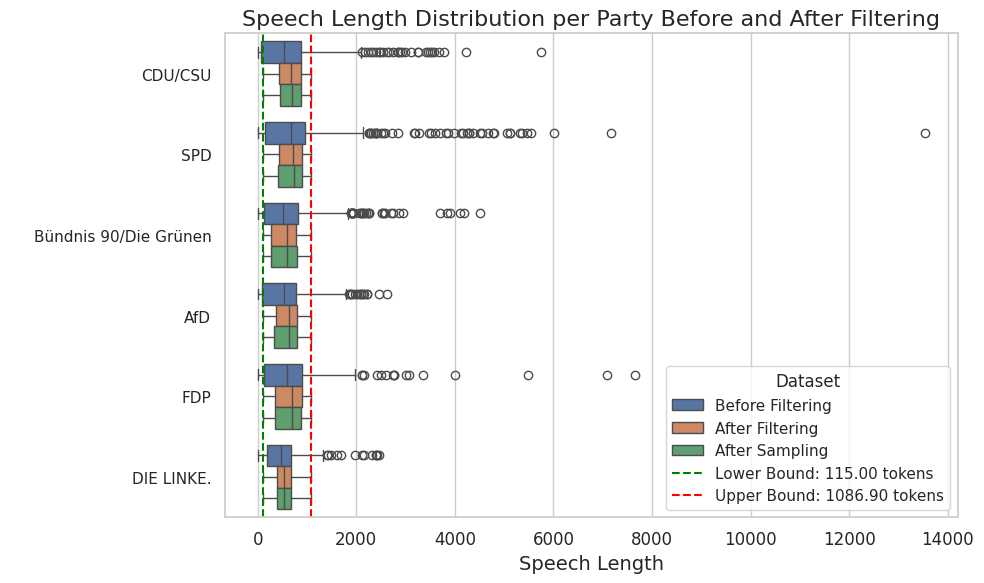

Map:   0%|          | 0/3900 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (815 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

/tmp/ipython-input-5-1444749384.py:348: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,No log,1.382053,0.442222,0.403970
2,No log,1.311347,0.455556,0.428475
3,1.374400,1.157316,0.545556,0.538548
4,1.374400,1.204031,0.568889,0.560307
5,0.847400,1.213764,0.561111,0.552747


[Saved] Best checkpoint written to: models/BERT_WINDOW_LOGIT_AGGREGATOR_best



Classification Report BERT_WINDOW_LOGIT_AGGREGATOR:
                       precision  recall  f1-score   support
AfD                        0.903   0.695     0.785   200.000
Bündnis 90/Die Grünen      0.397   0.465     0.429   200.000
CDU/CSU                    0.561   0.555     0.558   200.000
DIE LINKE.                 0.594   0.855     0.701   200.000
FDP                        0.329   0.270     0.297   200.000
SPD                        0.377   0.305     0.337   200.000
accuracy                   0.524   0.524     0.524     0.524
macro avg                  0.527   0.524     0.518  1200.000
weighted avg               0.527   0.524     0.518  1200.000

=== Evaluation Results for BERT_WINDOW_LOGIT_AGGREGATOR ===



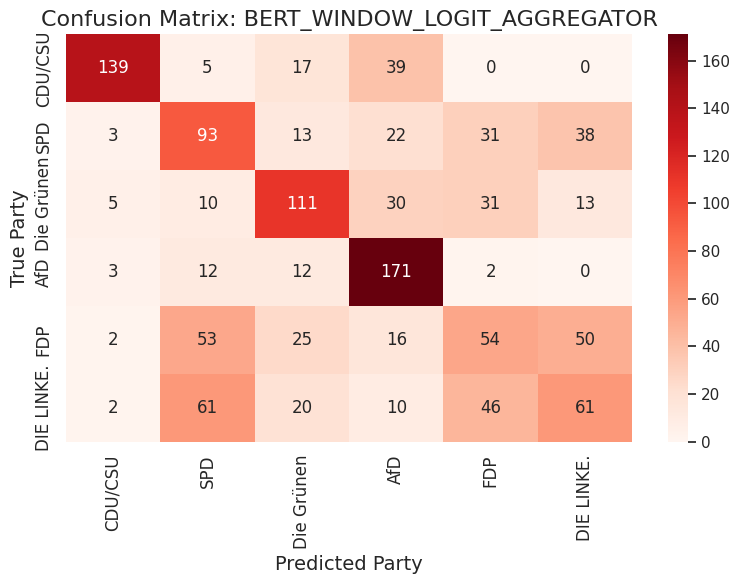


**Confusion Matrix (absolute counts)**

|            |   AfD |   Die Grünen |   CDU/CSU |   DIE LINKE. |   FDP |   SPD |
|:-----------|------:|-------------:|----------:|-------------:|------:|------:|
| AfD        |   139 |            5 |        17 |           39 |     0 |     0 |
| Die Grünen |     3 |           93 |        13 |           22 |    31 |    38 |
| CDU/CSU    |     5 |           10 |       111 |           30 |    31 |    13 |
| DIE LINKE. |     3 |           12 |        12 |          171 |     2 |     0 |
| FDP        |     2 |           53 |        25 |           16 |    54 |    50 |
| SPD        |     2 |           61 |        20 |           10 |    46 |    61 |


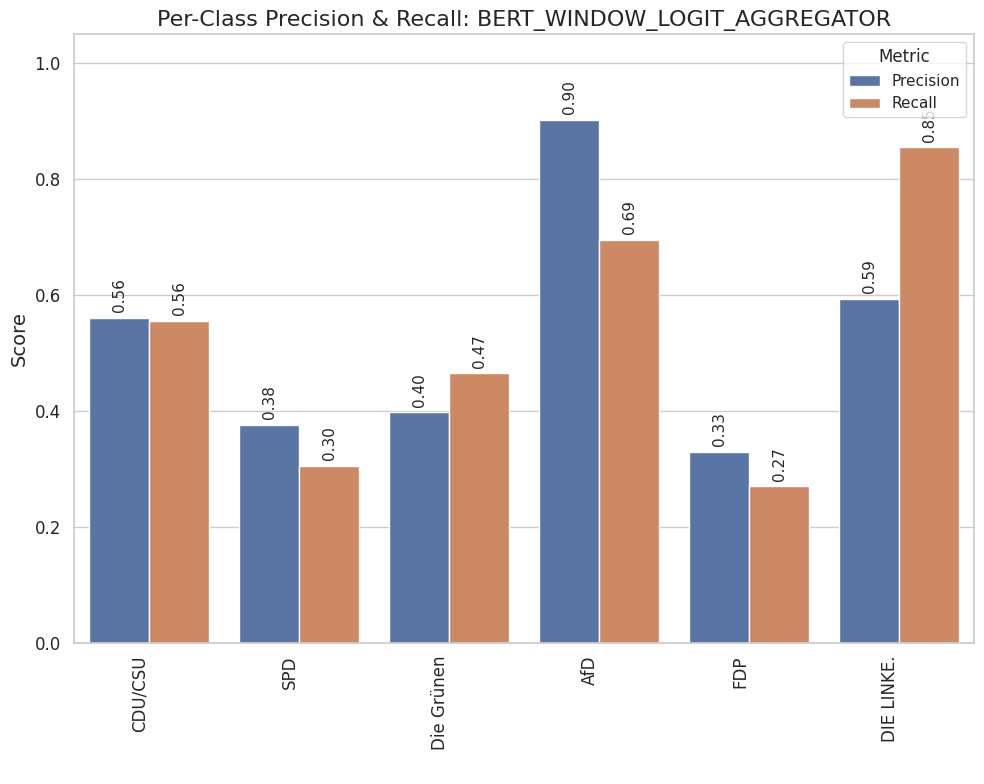


Classification Report:
            precision  recall  f1-score  support
AfD             0.903   0.695     0.785    200.0
Die Grünen      0.397   0.465     0.429    200.0
CDU/CSU         0.561   0.555     0.558    200.0
DIE LINKE.      0.594   0.855     0.701    200.0
FDP             0.329   0.270     0.297    200.0
SPD             0.377   0.305     0.337    200.0


In [5]:
# Running in Google Colab
#!pip install -q -U "transformers>=4.41.1" "datasets>=2.19.0" "evaluate>=0.4.0" "accelerate" "scikit-learn" "tqdm" "matplotlib" "seaborn"


def evaluate_model_results(model_name):
    """
    Evaluates classification results for the given model using abbreviations only.
    Produces plots for confusion matrix, precision, and recall per class.

    :param model_name (str): Identifier for result lookup and plots.
    """
    sns.set(style="whitegrid")

    print(f"\n=== Evaluation Results for {model_name} ===\n")

    # Define party order and colors
    order = ["CDU/CSU", "SPD", "Die Grünen", "AfD", "FDP", "DIE LINKE."]
    party_colors = {
        "CDU/CSU": "#000000",
        "SPD": "#E3000F",
        "Die Grünen": "#46962B",
        "FDP": "#FFED00",
        "AfD": "#009EE0",
        "DIE LINKE.": "#BE3075",
    }

    # Load and normalize evaluation data
    raw_cm = confusion_matrices[model_name]["matrix"]
    raw_labels = confusion_matrices[model_name]["labels"]
    raw_report = classification_reports[model_name]

    # Normalize label names (e.g., replace "Bündnis 90 / Die Grünen" with "Die Grünen")
    label_mapping = {
        "Bündnis 90/Die Grünen": "Die Grünen"
    }

    # Apply label mapping
    labels = [label_mapping.get(label, label) for label in raw_labels]

    # Remap confusion matrix to use normalized labels
    label_indices = {old: i for i, old in enumerate(raw_labels)}
    norm_indices = [label_mapping.get(label, label) for label in raw_labels]

    cm_df = pd.DataFrame(raw_cm, index=labels, columns=labels)

    # Remap classification report keys
    report = {}
    for label in raw_labels:
        mapped_label = label_mapping.get(label, label)
        report[mapped_label] = raw_report[label]

    # Label order
    label_order = [label for label in order if label in labels]

    # --- Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Reds", xticklabels=label_order, yticklabels=label_order)
    plt.xlabel("Predicted Party", fontsize=14)
    plt.ylabel("True Party", fontsize=14)
    plt.title(f"Confusion Matrix: {model_name}", fontsize=16)
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Print Confusion Matrix as Markdown table
    print("\n**Confusion Matrix (absolute counts)**\n")
    print(cm_df.to_markdown())

    # --- Combined Precision and Recall Plot ---
    df_combined = pd.DataFrame({
        "Party": label_order * 2,
        "Metric": ["Precision"] * len(label_order) + ["Recall"] * len(label_order),
        "Value": [report[label]["precision"] for label in label_order] +
                 [report[label]["recall"] for label in label_order],
        "Color": [party_colors[label] for label in label_order] * 2
    })

    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=df_combined,
        x="Party",
        y="Value",
        hue="Metric",
        dodge=True,
        palette={"Precision": "#4c72b0", "Recall": "#dd8452"}
    )

    # Annotate each bar with its value
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f"{height:.2f}",
                        (p.get_x() + p.get_width() / 2., height + 0.01),
                        ha='center', va='bottom', rotation=90, fontsize=11)

    plt.ylim(0, 1.05)
    plt.title(f"Per-Class Precision & Recall: {model_name}", fontsize=16)
    plt.ylabel("Score", fontsize=14)
    plt.xlabel(" ")
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=90, ha="right")
    plt.legend(title="Metric", loc="upper right")
    plt.tight_layout()
    plt.show()

    # --- Full Report ---
    report_df = pd.DataFrame(report).transpose()
    print("\nClassification Report:")
    print(report_df[["precision", "recall", "f1-score", "support"]].round(3))



from transformers.modeling_outputs import SequenceClassifierOutput
class BertWindowLogitAggregator(nn.Module):
    """
    BERT → CLS → *per-window* logits → mean-aggregation
    """
    def __init__(self, model_name, num_labels,
                 max_length=512, overlap=128, p_dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(p_dropout)

        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(self.bert.config.hidden_size, num_labels)
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.max_length = max_length
        self.overlap = overlap

    # ------------------------------------------------------------------ #
    # helper: run one *long* sequence through sliding windows,           #
    #         classify every window, then aggregate their logits         #
    # ------------------------------------------------------------------ #
    def _sliding_window_logits(self, input_ids, attention_mask, device):
        ids, mask = input_ids.tolist(), attention_mask.tolist()

        step = self.max_length - self.overlap
        segments, seg_masks = [], []
        for i in range(0, len(ids), step):
            chunk_ids  = ids[i : i + self.max_length]
            chunk_mask = mask[i : i + self.max_length]
            pad_len = self.max_length - len(chunk_ids)
            if pad_len:
                chunk_ids  += [tokenizer.pad_token_id] * pad_len
                chunk_mask += [0] * pad_len
            segments.append(chunk_ids)
            seg_masks.append(chunk_mask)

        segments  = torch.tensor(segments,  dtype=torch.long, device=device)
        seg_masks = torch.tensor(seg_masks, dtype=torch.long, device=device)
        seg_types = torch.zeros_like(segments)

        # -- CLS embedding of every window ----------------------------------
        cls_embs = self.bert(
            input_ids     = segments,
            attention_mask= seg_masks,
            token_type_ids= seg_types
        ).last_hidden_state[:, 0, :]                     # (n_seg, H)

        # -- logits of every window -----------------------------------------
        window_logits = self.classifier(self.dropout(cls_embs))  # (n_seg, C)

        # -- aggregate: mean over windows -----------------------------------
        agg_logits = window_logits.mean(dim=0)                     # (C,)
        return agg_logits

    def forward(self, input_ids, attention_mask, labels=None):
        device = input_ids.device
        batch_logits = []

        for i in range(input_ids.size(0)):
            seq_len = int(attention_mask[i].sum())

            if seq_len > self.max_length:                      # long → windows
                logits = self._sliding_window_logits(
                    input_ids[i], attention_mask[i], device
                )
            else:                                              # ≤512 tokens
                ids_slice   = input_ids[i, :seq_len].unsqueeze(0)
                mask_slice  = attention_mask[i, :seq_len].unsqueeze(0)
                types_slice = torch.zeros_like(ids_slice)

                cls_emb = self.bert(
                    input_ids      = ids_slice,
                    attention_mask = mask_slice,
                    token_type_ids = types_slice
                ).last_hidden_state[0, 0, :]                   # (H,)

                logits = self.classifier(self.dropout(cls_emb))  # (C,)

            batch_logits.append(logits)

        logits = torch.stack(batch_logits)                     # (B, C)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)



"""
Setup constants
"""
# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Models & Tokenizer
MODEL_NAME = "bert-base-german-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
LEARNING_RATE = 2e-5
NUM_LABELS = 6  # will later also be adjustet based on the number of uniqe parties in the dataset
BATCH_SIZE = 16
EPOCHS = 5
MAX_SAMPLE_SIZE_PARTY=1000 # speech counts of parties need to be double checked after filtering
TEST_SPLIT_SIZE=0.2
VALIDATION_SPLIT_SIZE = 0.15
UPPER_PERCENTILE = 0.9
LOWER_PERCENTILE = 0.25                                  # NEW
MODEL_SAVE_BASE_DIR = "models"
os.makedirs(MODEL_SAVE_BASE_DIR, exist_ok=True)



"""
Global variables
"""
# Global dictionary to store all confusion matrices by model name
confusion_matrices = {}
# Global dictionary to collect classification reports per model
classification_reports = {}
# Load faction map
faction_map = pd.read_pickle("factionsAbbreviations.pkl").drop_duplicates(subset="id").set_index("id")["abbreviation"]
# Set device type explicitly for MPS (Apple Silicon), CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



"""
Tokenization and dataset conversion
"""
def remove_contribution_markers(text: str) -> str:
    """
    - collapses whitespace
    - Removes content in square brackets like [Beifall], [Zwischenruf], etc.
    - Removes contribution position placeholders in the form of ({123})

    :param text (str): Raw speech text
    :return text (str): Normalized speech text
    """
    if not isinstance(text, str):
        return text  # Skip non-string entries (if any)
    text = re.sub(r'\[.*?\]', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r'\(\{\d+\}\)', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def prepare_dataset_BERT(df):
    """
    Wandelt das DataFrame in ein HF-Dataset ohne globales Padding um.
    Jede Rede bleibt in voller Länge erhalten; gepolstert
    wird erst *im* Batch durch den DataCollator.
    """
    df["speech_content"] = df["speech_content"].apply(remove_contribution_markers)
    ds = Dataset.from_pandas(df[["speech_content", "label_encoded"]])

    ds = ds.map(
        lambda x: tokenizer(
            x["speech_content"],
            add_special_tokens=True,   # [CLS] … [SEP]
            padding=False,             # **kein** Padding hier!
            truncation=False           # wir schneiden nicht ab – Sliding Window macht das später
        ),
        batched=True
    )

    ds = ds.rename_column("label_encoded", "labels")
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }



"""
Training Loop for BERT on mean pooling embeddings
"""
def train_bert_cls_sliding_window(train_df, test_df, val_df, model_name):
    """
    Training Loop for BERT

    :param: train_df (Dataset): training dataset.
    :param: test_df (Dataset): testing dataset.
    :param: model_name (str): Identifier for logging and visualizations.

    :return: None
    """
    # Prepare Datasets (Train, Val, Test)
    train_ds = prepare_dataset_BERT(train_df)
    val_ds   = prepare_dataset_BERT(val_df)
    test_ds  = prepare_dataset_BERT(test_df)

    # Initialize BERT model and trainer and move to device
    model = BertWindowLogitAggregator(MODEL_NAME, NUM_LABELS).to(device)

    # Set training arguments for the HuggingFace trainer
    training_args = TrainingArguments(
        output_dir="tmp",                 # Pflicht-Arg!
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        report_to="none",
        run_name="BERT_CLS_SLIDING_WINDOW"
    )

    collator = DataCollatorWithPadding(
        tokenizer,
        pad_to_multiple_of=8, # CUDA-friendly; für CPU einfach weglassen
        return_tensors="pt"
    )

    # Trainer object initialization
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(3, 0.0)]
    )

    # train model
    trainer.train()


    # >>>>>>>>>>>>>>>>>>>>> SAVE BEST MODEL <<<<<<<<<<<<<<<<<<<<<<<<<<<<<< #
    best_dir = Path(MODEL_SAVE_BASE_DIR) / f"{model_name}_best"
    best_dir.mkdir(parents=True, exist_ok=True)
    # 1) HF-style model & config
    trainer.save_model(best_dir)
    # 2) tokenizer (vocab, special tokens, etc.)
    tokenizer.save_pretrained(best_dir)
    # 3) fitted LabelEncoder (needed for inference)
    with open(best_dir / "label_encoder.pkl", "wb") as f:
        pickle.dump(encoder, f)
    print(f"[Saved] Best checkpoint written to: {best_dir}")
    # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< #


    # Predicting and decoding labels
    preds = trainer.predict(test_ds)
    y_true_enc = preds.label_ids
    y_pred_enc = np.argmax(preds.predictions, axis=1)

    # Map to faction abbreviations for readability
    y_true_abbr = test_df.reset_index(drop=True).iloc[:, :]["label_encoded"].map(label_to_fid).map(faction_map)
    y_pred_abbr = pd.Series(y_pred_enc).map(label_to_fid).map(faction_map)

    # Get sorted unique abbreviations for consistent plotting
    unique_abbr = sorted(y_true_abbr.unique())


    # Compute confusion matrix
    cm_local = confusion_matrix(y_true_abbr, y_pred_abbr, labels=unique_abbr)
    confusion_matrices[model_name] = {
        "matrix": cm_local,
        "labels": unique_abbr
    }

    # Classification report using readable party names
    report = classification_report(
        y_true_abbr,
        y_pred_abbr,
        labels=unique_abbr,
        target_names=unique_abbr,
        digits=3,
        output_dict=True
    )
    classification_reports[model_name] = report

    print(f"\nClassification Report {model_name}:")
    print(pd.DataFrame(report).transpose().round(3))



"""
Load and encode data
"""

# Load full raw dataset with raw speech text and faction_id
df = pd.read_pickle("speech_content_20.pkl")
# Drop rows with missing labels or empty text
df = df[df["faction_id"] != -1].dropna(subset=["speech_content"])
# Filter valid faction (without fraktionslos)
valid_ids = [0, 3, 4, 5, 7, 15, 25]
df = df[df["faction_id"].isin(valid_ids)].copy()
df.loc[df["faction_id"] == 3, "faction_id"] = 7 # merging BSW into DIE LINKE.
# add abbreviations to data set
df["faction_abbreviation"] = df["faction_id"].map(faction_map)

# encode labels (necessary for good BERT classification)
encoder = LabelEncoder()
df["label_encoded"] = encoder.fit_transform(df["faction_id"]) # column will later be named label
NUM_LABELS = len(encoder.classes_)
# label_encoded → original faction_id
label_to_fid = dict(zip(df["label_encoded"], df["faction_id"]))



"""
Filter speech lengths for BERT and SVM Models
"""
# Token count via tokenizer with progress bar
tqdm.pandas(desc="Counting tokens")
df["token_count"] = df["speech_content"].progress_apply(lambda text: len(tokenizer.tokenize(text)))

# copy for plt
df_old = df.copy()

# Outlier filtering using Quantils
lower_bound = df["token_count"].quantile(LOWER_PERCENTILE)
upper_bound = df["token_count"].quantile(UPPER_PERCENTILE)

# filter and report
df = df[(df["token_count"] >= lower_bound) & (df["token_count"] <= upper_bound)]
max_speech = df["token_count"].max()
print(f"Removed {len(df_old) - len(df)} speeches due to outlier speech length. {len(df)} speeches remain. The length speech is {max_speech} tokens long.")



"""
Unified Train-Test Split and Balanced Sampling for BERT and SVM Models
"""
# Balanced Sampling
balanced_df = pd.concat([
    party_df.sample(min(len(party_df), MAX_SAMPLE_SIZE_PARTY), random_state=SEED)
    for _, party_df in df.groupby("label_encoded")
])
# copy for plot
df_after_sampling = balanced_df.copy()

# Anzeige
sample_counts = balanced_df.groupby("label_encoded").agg(
    num_samples=("label_encoded", "count"),
    faction_id=("faction_id", "first"),
    faction_abbreviation=("faction_abbreviation", "first")
).reset_index().rename(columns={"label_encoded": "label_encoded (used for training)"})
print("\n=== Sample Counts per Class after Balanced Sampling ===\n")
print(sample_counts.to_string(index=False))

# === grouped Boxplot df_old and df ===
df_old["Status"] = "Before Filtering"
df["Status"] = "After Filtering"
df_after_sampling["Status"] = "After Sampling"
# combine
df_combined = pd.concat([df_old, df, df_after_sampling], axis=0)
# bpxplot
order = ["CDU/CSU", "SPD", "Bündnis 90/Die Grünen", "AfD", "FDP", "DIE LINKE."]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x="token_count", y="faction_abbreviation", hue="Status", order=order, showfliers=True)
plt.axvline(lower_bound, color="green", linestyle="--", label=f"Lower Bound: {lower_bound:.2f} tokens")
plt.axvline(upper_bound, color="red", linestyle="--", label=f"Upper Bound: {upper_bound:.2f} tokens")
plt.title("Speech Length Distribution per Party Before and After Filtering", fontsize=16)
plt.xlabel("Speech Length", fontsize=14)
plt.ylabel(" ")
plt.xticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)
plt.legend(title="Dataset", loc="lower right")
plt.tight_layout()
save_and_show_plot("grouped Boxplot df_old and df BERT_WINDOW_LOGIT_AGGREGATOR.png")

# Unified Train-Test Split (Train/Val/Test)
train_df, temp_df = train_test_split(
    balanced_df,
    test_size=TEST_SPLIT_SIZE + VALIDATION_SPLIT_SIZE,
    stratify=balanced_df["label_encoded"],
    random_state=SEED
)
val_size_rel = VALIDATION_SPLIT_SIZE / (TEST_SPLIT_SIZE + VALIDATION_SPLIT_SIZE)
val_df, test_df = train_test_split(
    temp_df,
    test_size=1 - val_size_rel,
    stratify=temp_df["label_encoded"],
    random_state=SEED
)



"""
Start BERT training and evaluation
"""
# Tokenization and training for BERT_MEAN
train_bert_cls_sliding_window(train_df, test_df, val_df, "BERT_WINDOW_LOGIT_AGGREGATOR")
evaluate_model_results("BERT_WINDOW_LOGIT_AGGREGATOR")


### **What changed:**

Replace the single MLP with a residual head so deeper non-linear features flow without degradation.
Add gradient_accumulation_steps=4 to virtually quadruple the batch while fitting in memory, and switch the optimiser to a cosine decay schedule with a 10 % warm-up and 0.01 weight-decay for smoother convergence.
Finally, scrap the simple hold-out split and wrap the whole training routine in a stratified 5-fold loop using StratifiedKFold; this yields a stable macro-F1 mean ± std and guards against lucky splits.

- ResidualHead: two linear layers with a skip connection replace the shallow
    MLP, allowing deeper feature interactions without degradation.
- Gradient accumulation quadruples the effective batch size while staying
    inside GPU memory.
- Cosine LR schedule with 10 % warm-up and 0.01 weight-decay yields smoother,
    more stable optimisation.
- Stratified 5-fold CV replaces the single hold-out split, producing a
    robust macro-F1 mean ± std and avoiding lucky or unlucky splits.


## **Segment-Level Voting Ensemble: Performance Review and Comparative Assessment**

Building upon the limitations identified in the **BERT_CLS_SLIDING_WINDOW** architecture, a new segment-level ensemble strategy was introduced: **BERT_WINDOW_LOGIT_AGGREGATOR**. This approach aggregates classification decisions across all overlapping speech segments by **summing logits prior to softmax**, effectively performing a **voting ensemble** across segment-wise predictions. The motivation was to retain local discriminative capacity of individual segments while mitigating over-smoothing effects from naive vector averaging.

### **Performance Overview**

- With a **macro F1-score of 0.518** and an overall **accuracy of 52.4 %**, the voting-based ensemble performs **on par with the previous CLS-pooling sliding window** model, slightly below **BERT_MEAN** (F1 = 0.554) but substantially ahead of the initial mean-pooling variant (F1 = 0.257).
- The validation progression across epochs shows clear optimization gains, culminating in the best performance at **epoch 4**, suggesting stable generalization despite the model's added complexity.

### **Class-Level Behavior**

- **AfD** and **DIE LINKE.** remain the strongest-performing classes, with F1-scores of 0.785 and 0.701 respectively. These high scores, particularly the **recall of 85.5 %** for DIE LINKE., confirm that the model reliably captures faction-specific rhetorical signals when they are ideologically distinctive and topically coherent.
- **CDU/CSU** now yields the **highest class-wise F1-score among the centrist parties** (0.558), indicating that the ensemble was able to preserve signal across multiple segments without collapsing to majority class predictions—a notable improvement in latent space structure.
- However, **SPD** and **FDP** remain difficult to distinguish, both hovering near or below 0.34 F1. These parties share broad lexical overlap and often employ procedural or neutral language, which remains a challenge for contextualized models regardless of context window size.

### **Comparative Assessment**

While the **segment-level voting ensemble avoids many of the pitfalls** of earlier pooling strategies, its performance still falls short of the **simpler BERT_MEAN baseline** in aggregate. This raises several interpretative considerations:

- First, **segment-wise classification with logit aggregation** appears to successfully reduce noise from uninformative segments and avoids washing out critical signal—as previously observed with mean pooling. However, the improvement is mostly **stabilizing**, not transformative.
- Second, the results **reinforce the hypothesis that longer input context alone is not the bottleneck**. Even with more context preserved and structured aggregation applied, the model fails to consistently outperform a truncated model trained on the first 512 tokens only. This suggests that **useful party-specific signals may be sufficiently front-loaded** in many speeches or that **transformer attention already saturates beyond a certain token horizon**.
- Finally, these outcomes deepen the puzzle raised by the earlier success of **TF-IDF-based SVM models**: despite having no access to contextual embeddings, they remain highly competitive. This implies that **global lexical patterns may still dominate party classification performance** and that modern transformers may underexploit these shallow but highly discriminative features unless explicitly guided.

### **Conclusion and Outlook**

The **BERT_WINDOW_LOGIT_AGGREGATOR** architecture represents a meaningful architectural refinement, offering **more interpretable and robust segment aggregation** than naive mean or CLS pooling. Nevertheless, its **marginal performance advantage does not yet justify the added complexity**, especially when viewed in light of simpler, more efficient baselines.

To unlock further improvements, future research should explore **adaptive attention over segment outputs**, **hierarchical transformers** that natively model document structure, or **hybrid approaches** combining global TF-IDF features with local contextual embeddings in late-fusion ensembles. More fundamentally, the findings prompt a reconsideration of what "context" truly means in the party classification task—and whether **rhetorical salience, rather than token count**, should guide architectural decisions.



---


Back to [`ML-Task-1: Classification`](ML-Task-1_Classification.ipynb) ...

Back to [`ML-Task-1: Vecorization Experiment`](ML-Task-1_Vectorization_Experiment.ipynb) ...




## **How to reload the saved model later:**

```
from transformers import BertTokenizer, BertForSequenceClassification
import torch, pickle
model_dir = "models/BERT_WINDOW_LOGIT_AGGREGATOR_best"

tokenizer = BertTokenizer.from_pretrained(model_dir)
model     = BertForSequenceClassification.from_pretrained(model_dir)
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

with open(Path(model_dir) / "label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

text = "Sehr geehrter Herr Präsident, ..."
inputs = tokenizer(text, return_tensors="pt").to(device)
pred   = torch.argmax(model(**inputs).logits, dim=1).item()
faction_id = label_encoder.inverse_transform([pred])[0]
```